In [1]:
#Files needed for this code to work:
#1. 1_EmoWoz_Dataset.xlsx which was created in 0_EmoWoz_Setup.ipynb

# Step 1: Import required packages

In [44]:
import torch
import pandas as pd
import numpy as np
from transformers import pipeline
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vicedeputy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2: Load in EmoWoz texts and correct sentiment labels into a list and clean that list

In [4]:
# Load the Excel file
emowoz_df = pd.read_excel("1_EmoWoz_Dataset.xlsx")

# Convert the DataFrame to a list
emowoz_list = emowoz_df.values.tolist()
emowoz_list[:10]

[['Thanks so much. I am also looking for places to go in town. Can you help me with that?',
  2,
  6,
  'Positive',
  'Satisfied, liking'],
 ['Thank you.  That was all I needed.', 2, 6, 'Positive', 'Satisfied, liking'],
 ['No. I need to depart from Cambridge and leave on Monday. Can you find me a more suitable train?',
  1,
  2,
  'Negative',
  'Dissatisfied, disliking'],
 ["That's all I need. Thank you!", 2, 6, 'Positive', 'Satisfied, liking'],
 ['Thank you and goodbye.', 2, 6, 'Positive', 'Satisfied, liking'],
 ["Good day. I'm headed into town and I need help finding a guesthouse that offers free wifi please",
  2,
  5,
  'Positive',
  'Excited, happy, anticipating'],
 ["Okay, i'll try it out!  Book me for 6 people, 2 nights starting this monday.",
  2,
  6,
  'Positive',
  'Satisfied, liking'],
 ['Thank you.  Yes, I also need to find a moderately priced Italian restaurant.',
  2,
  6,
  'Positive',
  'Satisfied, liking'],
 ["Yes, let's go for the one in Regent Street City Centre. It

In [5]:
#Double checking all 20219 rows of dialogue are loaded
len(emowoz_list)

20219

In [7]:
#Iterate over all elements in emowoz_list to extract i) the actual texts from each speaker turn into a list (the first element of each nested list) ii) the correct sentiments in a separate list (the fourth element of each nested list)
emowoz_text = []
emowoz_correct_sentiment = []
for speaker_turn in emowoz_list:
    emowoz_text.append(speaker_turn[0])
    emowoz_correct_sentiment.append(speaker_turn[3])

In [8]:
#Paste to see list of Emowoz speaker turns
emowoz_text[:10]

['Thanks so much. I am also looking for places to go in town. Can you help me with that?',
 'Thank you.  That was all I needed.',
 'No. I need to depart from Cambridge and leave on Monday. Can you find me a more suitable train?',
 "That's all I need. Thank you!",
 'Thank you and goodbye.',
 "Good day. I'm headed into town and I need help finding a guesthouse that offers free wifi please",
 "Okay, i'll try it out!  Book me for 6 people, 2 nights starting this monday.",
 'Thank you.  Yes, I also need to find a moderately priced Italian restaurant.',
 "Yes, let's go for the one in Regent Street City Centre. It will be on Monday, at 19:15, and there will be 6 people. ",
 'thank you that will be all']

In [9]:
#Paste to see list of correct sentiments for each speaker turn
emowoz_correct_sentiment[:10]

['Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive',
 'Positive']

# Step 3: Text pre-processing

In [11]:
#Want to make processing faster by i) cleaning text and ii) removing stopwords. 

## Step 3.1 Cleaning EmoWoz text

In [10]:
#Use re module 
#First need to copy emowoz_text list into new list so that we preserve the actual texts from the EmoWoz library for later
emowoz_text_clean = emowoz_text.copy()
#Then clean text by removing non-sentiment relevant words
for i in range(len(emowoz_text_clean)):
    #lowercase font
    emowoz_text_clean[i] =  emowoz_text_clean[i].lower()
    #remove numbers
    emowoz_text_clean[i]=re.sub('[0-9]{1,}(,[0-9]{3}){0,}(\.[0-9]{1,}){0,1}','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bzero\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bone\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\btwo\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bthree\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bfour\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bfive\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bsix\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bseven\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\beight\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bnine\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bten\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\beleven\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\btwelve\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bthirteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bfourteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bfifteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bsixteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bseventeen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\beighteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\bnineteen\b','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub(r'\btwenty\b','',emowoz_text_clean[i])
    #removing contractions
    contractions={
        re.compile("amn't"): "am not",
        re.compile("aren't"): "are not",
        re.compile("can't"): "cannot",
        re.compile("'cause"): "because",
        re.compile("could've"): "could have",
        re.compile("couldn't"): "could not",
        re.compile("couldn't've"): "could not have",
        re.compile("daresn't"): "dare not",
        re.compile("dasn't"): "dare not",
        re.compile("didn't"): "did not",
        re.compile("doesn't"): "does not",
        re.compile("e'er"): "ever",
        re.compile("g'day"): "good day",
        re.compile("gimme"): "give me",
        re.compile("giv'n"): "given",
        re.compile("gonna"): "going to",
        re.compile("gon't"): "go not",
        re.compile("gotta"): "got to",
        re.compile("hadn't"): "had not",
        re.compile("hasn't"): "has not",
        re.compile("haven't"): "have not",
        re.compile("he've"): "he have",
        re.compile("how'll"): "how will",
        re.compile("how're"): "how are",
        re.compile("i'd've"): "i would have",
        re.compile("i'm"): "i am",
        re.compile("i'm'a"): "i am about to",
        re.compile("i'm'o"): "i am going to",
        re.compile("innit"): "is it not",
        re.compile("i've"): "i have",
        re.compile("isn't"): "is not",
        re.compile("let's"): "let us",
        re.compile("ma'am"): "madam",
        re.compile("mayn't"): "may not",
        re.compile("may've"): "may have",
        re.compile("methinks"): "me thinks",
        re.compile("mightn't"): "might not",
        re.compile("might've"): "might have",
        re.compile("mustn't"): "must not",
        re.compile("mustn't've"): "must not have",
        re.compile("must've"): "must have",
        re.compile("needn't"): "need not",
        re.compile("ne'er"): "never",
        re.compile("o'clock"): "of the clock",
        re.compile("o'er"): "over",
        re.compile("ol'"): "old",
        re.compile("oughtn't"): "ought not",
        re.compile("shalln't"): "shall not",
        re.compile("shan't"): "shall not",
        re.compile("should've"): "should have",
        re.compile("shouldn't"): "should not",
        re.compile("shouldn't've"): "should not have",
        re.compile("so're"): "so are",
        re.compile("that're"): "that are",
        re.compile("there're"): "there are",
        re.compile("these're"): "these are",
        re.compile("they've"): "they have",
        re.compile("those're"): "those are",
        re.compile("'tis"): "it is",
        re.compile("to've"): "to have",
        re.compile("'twas"): "it was",
        re.compile("wanna"): "want to",
        re.compile("wasn't"): "was not",
        re.compile("we're"): "we are",
        re.compile("we've"): "we have",
        re.compile("we'd've"): "we would have",
        re.compile("weren't"): "were not",
        re.compile("what've"): "what have",
        re.compile("where're"): "where are",
        re.compile("where've"): "where have",
        re.compile("whilst"): "while still",
        re.compile("who're"): "who are",
        re.compile("who've"): "who have",
        re.compile("who'd've"): "who would have",
        re.compile("why're"): "why are",
        re.compile("won't"): "will not",
        re.compile("would've"): "would have",
        re.compile("wouldn't"): "would not",
        re.compile("you're"): "you are",
        re.compile("y'all"): "you all",
        re.compile("y'all're"): "you all are",
        re.compile("y'all'd've"): "you all would have",
        re.compile("you've"): "you have",
        re.compile("noun're"): "noun are"
        }
        
    non_unique_contractions={ # I list the meanings, which have not been selected as the most common translation next to each element in comments
        re.compile("ain't"): "am not", # is not / are not / has not / have not / did not
        re.compile("don't"): "do not", # does not
        re.compile("d'ye"): "do you", # did you
        re.compile("daren't"): "dare not", # dared not
        re.compile("everybody's"): "everybody is", # everybody has
        re.compile("everyone's"): "everyone is", # everyone has
        re.compile("finna"): "fixing to", # going to
        re.compile("he'd"): "he had", # he would
        re.compile("he'll"): "he will", # he shall
        re.compile("he's"): "he is", # he has
        re.compile("how'd"): "how would", # how did
        re.compile("howdy"): "how do you do", # how do you fare
        re.compile("how's"): "how is", # how has / how does
        re.compile("i'd"): "I would", # I had
        re.compile("i'll"): "I will", # I shall
        re.compile("it'd"): "it would", # it had
        re.compile("it'll"): "it will", # it shall
        re.compile("it's"): "it is", # it has
        re.compile("she'd"): "she would", # she had
        re.compile("she'll"): "she will", # she shall
        re.compile("she's"): "she is", # she has
        re.compile("somebody's"): "somebody is", # somebody has
        re.compile("someone's"): "someone is", # someone has
        re.compile("something's"): "something is", # something has
        re.compile("that'll"): "that will", # that shall
        re.compile("that's"): "that is", # that has
        re.compile("that'd"): "that would", # that had
        re.compile("there'd"): "there would", # there had 
        re.compile("there'll"): "there will", # there shall
        re.compile("there's"): "there is", # there has
        re.compile("they'd"): "they would", # they had
        re.compile("they'll"): "they will", # they shall
        re.compile("they're"): "they are", # they were
        re.compile("this's"): "this is", # this has
        re.compile("we'd"): "we would", # we had / we did
        re.compile("we'll"): "we will", # we shall       
        re.compile("what'd"): "what did", # what would / what had
        re.compile("what'll"): "what will", # what shall / what all
        re.compile("what's"): "what is", # what has / what does
        re.compile("what're"): "what are", # what were
        re.compile("when's"): "when is", # when has
        re.compile("where'd"): "where did", # where would / where had
        re.compile("where's"): "where is", # where has / where does
        re.compile("which'll"): "which will", # which shall
        re.compile("which's"): "which is", # which has
        re.compile("who'd"): "who would ", # who had / who did
        re.compile("who'll"): "who will", # who shall
        re.compile("who's"): "who is", # who has / who does
        re.compile("why'd"): "why did", # why had / why would
        re.compile("why's"): "why is", # why has / why does
        re.compile("you'd"): "you would", # you had / you did
        re.compile("you'll"): "you will", # you shall
        re.compile("noun's"): "noun is", # noun has      
        }
        
    for rx,repl in contractions.items(): # replace contractions items
        emowoz_text_clean[i] = rx.sub(repl, emowoz_text_clean[i])
        
    for rx,repl in non_unique_contractions.items(): # replace non-unique contractions items
        emowoz_text_clean[i] = rx.sub(repl, emowoz_text_clean[i])
            
    emowoz_text_clean[i]=re.sub("'[a-z]+",'',emowoz_text_clean[i]) # remove any remaining contractions
    
    # Delete the minus/hyphens
    # "Short-term" -> "shortterm"
    emowoz_text_clean[i]=re.sub('-{1,}','',emowoz_text_clean[i])
    
    # Delete single character words
    # One can argue whether one should implement this procedure. Loughran and
    # McDonald argue in one of their papers in favor of it.
    # To make sure that there is just one letter, we require that there is a word
    # boundary (\W) before and after. We use a positive backward looking and a
    # positive forward looking condition for this to assure that the word boundary
    # get not deleted as well.
    emowoz_text_clean[i]=re.sub('(?i)(?<=\W)[a-z](?=\W)',' ',emowoz_text_clean[i])
    #delete symbols
    emowoz_text_clean[i]=re.sub('\(|\)|\[|\]|\$|§|%|\&|\^|\*|/|·|-|\"|\'|\+|\{|\}','',emowoz_text_clean[i])
    #remove punctuation
    emowoz_text_clean[i]=re.sub('\.|\?|\!|,|;|:|','',emowoz_text_clean[i])
    # Remove multiple whitespaces in a row
    emowoz_text_clean[i]=re.sub("\s+"," ",emowoz_text_clean[i])
    # Remove 'politeness clauses' like 'Good Morning', which include words that are part of the LMD positivity dictionary although the clauses do not indicate positive tone!
    emowoz_text_clean[i]=re.sub('good morning','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub('good evening','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub('nice day','',emowoz_text_clean[i])
    emowoz_text_clean[i]=re.sub('you are welcome','',emowoz_text_clean[i])

emowoz_text_clean

['thanks so much am also looking for places to go in town can you help me with that',
 'thank you that was all needed',
 'no need to depart from cambridge and leave on monday can you find me more suitable train',
 'that is all need thank you',
 'thank you and goodbye',
 'good day am headed into town and need help finding guesthouse that offers free wifi please',
 'okay will try it out book me for people nights starting this monday',
 'thank you yes also need to find moderately priced italian restaurant',
 'yes let us go for the in regent street city centre it will be on monday at and there will be people ',
 'thank you that will be all',
 'yes am sorry should have told you earlier',
 'thanks am also looking for multiple sports attraction in the centre of town ',
 'great thanks that is all need ',
 'can you recommend good for me will need the address and postcode',
 'yes would like to go to museum in the centre of town if price is no object what is the best ',
 'wonderful that is everyt

## Step 3.2 Removing stopwords

In [11]:
#Use of nltk library for removing stopwords
#First choose english stopwords and print out list of them to make sure it outputs list of english stopwords as intended.
stop_words = stopwords.words('english')
stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [12]:
#To optimize speed of iteration process, convert NLTK stopwords list into a set object. The difference between a set and a list is that a set can 
#only contain unique values while a list can contain duplicate values. Additionally, a set will not be saved in an ordered way meaning you can imput 
#it in a certain order but when printed the order will be different. Meanwhile, a list is ordered and will be returned in the same order you input it.
stop_words_set = set(stop_words)
#Next, we need to split the dialogue to convert it into a list of words where each list element is one word of the dialogue. Can do this with a list 
#comprehension
emowoz_text_lower_case = [word.split() for word in emowoz_text_clean]
emowoz_text_lower_case

[['thanks',
  'so',
  'much',
  'am',
  'also',
  'looking',
  'for',
  'places',
  'to',
  'go',
  'in',
  'town',
  'can',
  'you',
  'help',
  'me',
  'with',
  'that'],
 ['thank', 'you', 'that', 'was', 'all', 'needed'],
 ['no',
  'need',
  'to',
  'depart',
  'from',
  'cambridge',
  'and',
  'leave',
  'on',
  'monday',
  'can',
  'you',
  'find',
  'me',
  'more',
  'suitable',
  'train'],
 ['that', 'is', 'all', 'need', 'thank', 'you'],
 ['thank', 'you', 'and', 'goodbye'],
 ['good',
  'day',
  'am',
  'headed',
  'into',
  'town',
  'and',
  'need',
  'help',
  'finding',
  'guesthouse',
  'that',
  'offers',
  'free',
  'wifi',
  'please'],
 ['okay',
  'will',
  'try',
  'it',
  'out',
  'book',
  'me',
  'for',
  'people',
  'nights',
  'starting',
  'this',
  'monday'],
 ['thank',
  'you',
  'yes',
  'also',
  'need',
  'to',
  'find',
  'moderately',
  'priced',
  'italian',
  'restaurant'],
 ['yes',
  'let',
  'us',
  'go',
  'for',
  'the',
  'in',
  'regent',
  'street',
 

In [13]:
#Create a new list where all the stopwords are removed. Can do this with a two hierarchy-level list comprehension
emowoz_text_lower_case_no_stopwords = [([word for word in dialogue if word not in stop_words]) for dialogue in emowoz_text_lower_case]
emowoz_text_lower_case_no_stopwords

[['thanks', 'much', 'also', 'looking', 'places', 'go', 'town', 'help'],
 ['thank', 'needed'],
 ['need',
  'depart',
  'cambridge',
  'leave',
  'monday',
  'find',
  'suitable',
  'train'],
 ['need', 'thank'],
 ['thank', 'goodbye'],
 ['good',
  'day',
  'headed',
  'town',
  'need',
  'help',
  'finding',
  'guesthouse',
  'offers',
  'free',
  'wifi',
  'please'],
 ['okay', 'try', 'book', 'people', 'nights', 'starting', 'monday'],
 ['thank',
  'yes',
  'also',
  'need',
  'find',
  'moderately',
  'priced',
  'italian',
  'restaurant'],
 ['yes',
  'let',
  'us',
  'go',
  'regent',
  'street',
  'city',
  'centre',
  'monday',
  'people'],
 ['thank'],
 ['yes', 'sorry', 'told', 'earlier'],
 ['thanks',
  'also',
  'looking',
  'multiple',
  'sports',
  'attraction',
  'centre',
  'town'],
 ['great', 'thanks', 'need'],
 ['recommend', 'good', 'need', 'address', 'postcode'],
 ['yes',
  'would',
  'like',
  'go',
  'museum',
  'centre',
  'town',
  'price',
  'object',
  'best'],
 ['wonderf

In [16]:
#Now join words back together 
emowoz_text_cleaned = [' '.join(word) for word in emowoz_text_lower_case_no_stopwords]
emowoz_text_cleaned

['thanks much also looking places go town help',
 'thank needed',
 'need depart cambridge leave monday find suitable train',
 'need thank',
 'thank goodbye',
 'good day headed town need help finding guesthouse offers free wifi please',
 'okay try book people nights starting monday',
 'thank yes also need find moderately priced italian restaurant',
 'yes let us go regent street city centre monday people',
 'thank',
 'yes sorry told earlier',
 'thanks also looking multiple sports attraction centre town',
 'great thanks need',
 'recommend good need address postcode',
 'yes would like go museum centre town price object best',
 'wonderful everything needed thank',
 'thank much',
 'great could get address please',
 'everything',
 'I go nando thanks',
 'great get adress',
 'thank visit set thanks bookings goodbye',
 'parking car another driver passed close scraped paint acknowledge fault help',
 'thank much help',
 'perfect thanks much help',
 'ok think already established attraction town cen

# Step 4: Sentiment analysis

In [ ]:
#Sentiment analysis is performed with three different models: SieBERT, RoBERTa, and XLNet

In [15]:
# Load the three models
sentiment_analysis_siebert = pipeline('sentiment-analysis', model="siebert/sentiment-roberta-large-english", tokenizer="siebert/sentiment-roberta-large-english")
sentiment_analysis_roberta = pipeline('sentiment-analysis', model="philschmid/roberta-large-sst2", tokenizer="philschmid/roberta-large-sst2")
sentiment_analysis_xlnet = pipeline('sentiment-analysis', model="textattack/xlnet-base-cased-SST-2", tokenizer="textattack/xlnet-base-cased-SST-2")

config.json:   0%|          | 0.00/861 [00:00<?, ?B/s]

c:\Users\vicedeputy\miniconda3\envs\bachelor_thesis\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vicedeputy\.cache\huggingface\hub\models--philschmid--roberta-large-sst2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

c:\Users\vicedeputy\miniconda3\envs\bachelor_thesis\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\vicedeputy\.cache\huggingface\hub\models--textattack--xlnet-base-cased-SST-2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/469M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/202 [00:00<?, ?B/s]

In [17]:
# Initialize lists to store the sentiment labels
siebert_sentiment_labels = []
roberta_sentiment_labels = []
xlnet_sentiment_labels = []

# Feed the cleaned text into the SieBERT model
for text in tqdm(emowoz_text_cleaned, desc="SieBERT Sentiment Analysis"):
    siebert_sentiment_labels.append(sentiment_analysis_siebert(text, padding=True, truncation=True))

# Feed the cleaned text into the RoBERTa model
for text in tqdm(emowoz_text_cleaned, desc="RoBERTa Sentiment Analysis"):
    roberta_sentiment_labels.append(sentiment_analysis_roberta(text, padding=True, truncation=True))

# Feed the cleaned text into the XLNet model
for text in tqdm(emowoz_text_cleaned, desc="XLNet Sentiment Analysis"):
    xlnet_sentiment_labels.append(sentiment_analysis_xlnet(text, padding=True, truncation=True))

XLNet Sentiment Analysis: 100%|██████████| 20219/20219 [18:54<00:00, 17.82it/s]


In [19]:
#Showing the first 10 sentiment outputs from the Siebert model
siebert_sentiment_labels[:10]

[[{'label': 'POSITIVE', 'score': 0.9982964396476746}],
 [{'label': 'POSITIVE', 'score': 0.9976248145103455}],
 [{'label': 'NEGATIVE', 'score': 0.9856853485107422}],
 [{'label': 'POSITIVE', 'score': 0.9967156648635864}],
 [{'label': 'POSITIVE', 'score': 0.9981572031974792}],
 [{'label': 'POSITIVE', 'score': 0.9978117346763611}],
 [{'label': 'POSITIVE', 'score': 0.9974355101585388}],
 [{'label': 'POSITIVE', 'score': 0.9980514049530029}],
 [{'label': 'POSITIVE', 'score': 0.9988085031509399}],
 [{'label': 'POSITIVE', 'score': 0.9984540939331055}]]

In [20]:
#Showing the first 10 sentiment outputs from the RoBERTa model
roberta_sentiment_labels[:10]

[[{'label': 'positive', 'score': 0.9923189282417297}],
 [{'label': 'positive', 'score': 0.9979801774024963}],
 [{'label': 'negative', 'score': 0.8936282396316528}],
 [{'label': 'positive', 'score': 0.9961720108985901}],
 [{'label': 'positive', 'score': 0.9276072978973389}],
 [{'label': 'negative', 'score': 0.8442251086235046}],
 [{'label': 'negative', 'score': 0.6675218939781189}],
 [{'label': 'positive', 'score': 0.9802356958389282}],
 [{'label': 'positive', 'score': 0.998910665512085}],
 [{'label': 'positive', 'score': 0.9988081455230713}]]

In [21]:
#Showing the first 10 sentiment outputs from the XLNet model
xlnet_sentiment_labels[:10]

[[{'label': 'LABEL_1', 'score': 0.9909747242927551}],
 [{'label': 'LABEL_1', 'score': 0.9868180751800537}],
 [{'label': 'LABEL_0', 'score': 0.9757059812545776}],
 [{'label': 'LABEL_1', 'score': 0.5352509021759033}],
 [{'label': 'LABEL_1', 'score': 0.9232044816017151}],
 [{'label': 'LABEL_0', 'score': 0.8596898913383484}],
 [{'label': 'LABEL_1', 'score': 0.7002763748168945}],
 [{'label': 'LABEL_1', 'score': 0.6149630546569824}],
 [{'label': 'LABEL_1', 'score': 0.9622364640235901}],
 [{'label': 'LABEL_1', 'score': 0.9989493489265442}]]

# Step 5: Create dataframe with results

In [29]:
#for each model, extracting only the predicted sentiment label (i.e. positive or negative). Need two for loops as the sentiment predictions are in a list of lists
#For the XLNet model, need to convert the labels into actual readable sentiment scores. LABEL_1 is equivalent to positive sentiment and LABEL_0 is equivalent to negative sentiment. Can do this in two steps with a list comprehension
siebert_sentiment = [sentiment[0]['label'].title() for sentiment in siebert_sentiment_labels]
roberta_sentiment = [sentiment[0]['label'].title() for sentiment in roberta_sentiment_labels]
xlnet_sentiment = ['Positive' if sentiment[0]['label'] == 'LABEL_1' else 'Negative' for sentiment in xlnet_sentiment_labels]
print("SieBERT first 10 Sentiments:", siebert_sentiment[:10])
print("RoBERTa first 10 Sentiments:", roberta_sentiment[:10])
print("XLNet first 10 Sentiments:", xlnet_sentiment[:10])

SieBERT first 10 Sentiments: ['Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive', 'Positive']
RoBERTa first 10 Sentiments: ['Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Negative', 'Positive', 'Positive', 'Positive']
XLNet first 10 Sentiments: ['Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Negative', 'Positive', 'Positive', 'Positive', 'Positive']


In [34]:
# Create DataFrame with original EmoWoz dialogue, cleaned dialogue, model prediction and actual sentiment
# Create DataFrame with original EmoWoz dialogue, cleaned dialogue, model predictions for all three models and actual sentiment
emowoz_result_df = pd.DataFrame({
    'original_text': emowoz_text,
    'cleaned_text': emowoz_text_cleaned,
    'siebert_prediction': siebert_sentiment,
    'roberta_prediction': roberta_sentiment,
    'xlnet_prediction': xlnet_sentiment,
    'actual_sentiment': emowoz_correct_sentiment
})
emowoz_result_df

,original_text,cleaned_text,siebert_prediction,roberta_prediction,xlnet_prediction,actual_sentiment
0,Thanks so much. I am also looking for places t...,thanks much also looking places go town help,Positive,Positive,Positive,Positive
1,Thank you. That was all I needed.,thank needed,Positive,Positive,Positive,Positive
2,No. I need to depart from Cambridge and leave ...,need depart cambridge leave monday find suitab...,Negative,Negative,Negative,Negative
3,That's all I need. Thank you!,need thank,Positive,Positive,Positive,Positive
4,Thank you and goodbye.,thank goodbye,Positive,Positive,Positive,Positive
...,...,...,...,...,...,...
20214,Thank you goodbye.,thank goodbye,Positive,Positive,Positive,Positive
20215,"No, that is all. You have been very helpful. ...",helpful thanks bye,Positive,Positive,Positive,Positive
20216,We are visiting cambridge for the first time a...,visiting cambridge first time looking moderate...,Positive,Positive,Positive,Positive
20217,Can you recommend a tour of the college near t...,recommend tour college near hotel,Positive,Positive,Positive,Positive


In [37]:
#Add Boolean column that says if siebert_prediction = actual_sentiment
emowoz_result_df['siebert_correct'] = emowoz_result_df['siebert_prediction'] == emowoz_result_df['actual_sentiment']
emowoz_result_df['roberta_correct'] = emowoz_result_df['roberta_prediction'] == emowoz_result_df['actual_sentiment']
emowoz_result_df['xlnet_correct'] = emowoz_result_df['xlnet_prediction'] == emowoz_result_df['actual_sentiment']
emowoz_result_df[:10]

,original_text,cleaned_text,siebert_prediction,roberta_prediction,xlnet_prediction,actual_sentiment,siebert_correct,roberta_correct,xlnet_correct
0,Thanks so much. I am also looking for places t...,thanks much also looking places go town help,Positive,Positive,Positive,Positive,True,True,True
1,Thank you. That was all I needed.,thank needed,Positive,Positive,Positive,Positive,True,True,True
2,No. I need to depart from Cambridge and leave ...,need depart cambridge leave monday find suitab...,Negative,Negative,Negative,Negative,True,True,True
3,That's all I need. Thank you!,need thank,Positive,Positive,Positive,Positive,True,True,True
4,Thank you and goodbye.,thank goodbye,Positive,Positive,Positive,Positive,True,True,True
5,Good day. I'm headed into town and I need help...,good day headed town need help finding guestho...,Positive,Negative,Negative,Positive,True,False,False
6,"Okay, i'll try it out! Book me for 6 people, ...",okay try book people nights starting monday,Positive,Negative,Positive,Positive,True,False,True
7,"Thank you. Yes, I also need to find a moderat...",thank yes also need find moderately priced ita...,Positive,Positive,Positive,Positive,True,True,True
8,"Yes, let's go for the one in Regent Street Cit...",yes let us go regent street city centre monday...,Positive,Positive,Positive,Positive,True,True,True
9,thank you that will be all,thank,Positive,Positive,Positive,Positive,True,True,True


# Step 6: Export results dataframe to Excel format

In [38]:
# Put the dataframe into an Excel file and save it
emowoz_result_df.to_excel("3_Sentiment_analysis_result.xlsx", index=False, engine='openpyxl')

# Step 7: Calculate results

In [40]:
# Calculate the accuracy for each model
siebert_accuracy = emowoz_result_df['siebert_correct'].mean()
roberta_accuracy = emowoz_result_df['roberta_correct'].mean()
xlnet_accuracy = emowoz_result_df['xlnet_correct'].mean()

# Create a DataFrame to display the accuracies
accuracy_df = pd.DataFrame({
    'Model': ['SieBERT', 'RoBERTa', 'XLNet'],
    'Accuracy': [siebert_accuracy, roberta_accuracy, xlnet_accuracy]
})

accuracy_df

,Model,Accuracy
0,SieBERT,0.917058
1,RoBERTa,0.885256
2,XLNet,0.864533


SieBERT Confusion Matrix:
 [[ 1461   807]
 [  870 17081]]
RoBERTa Confusion Matrix:
 [[ 1560   708]
 [ 1612 16339]]
XLNet Confusion Matrix:
 [[ 1557   711]
 [ 2028 15923]]


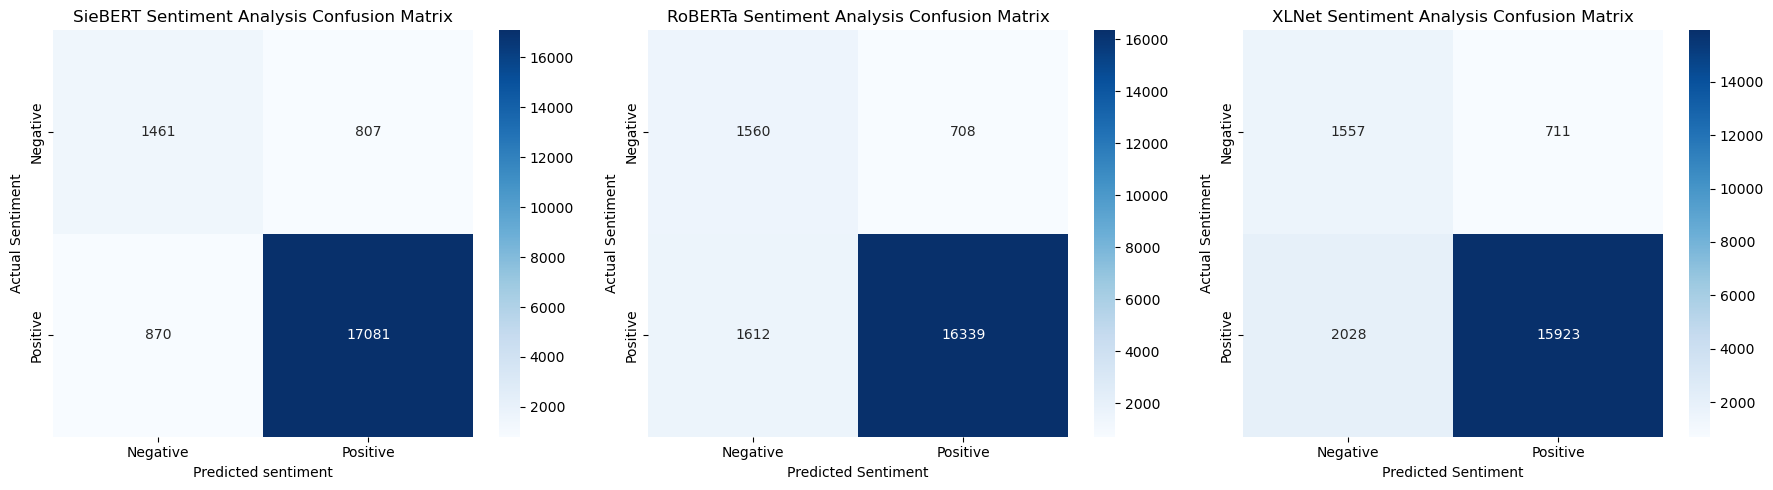

In [46]:
#Generate a confusion matrix for each model
# Generate confusion matrix for SieBERT model
siebert_confusion_matrix = confusion_matrix(emowoz_result_df['actual_sentiment'], emowoz_result_df['siebert_prediction'])
print("SieBERT Confusion Matrix:\n", siebert_confusion_matrix)

# Generate confusion matrix for RoBERTa model
roberta_confusion_matrix = confusion_matrix(emowoz_result_df['actual_sentiment'], emowoz_result_df['roberta_prediction'])
print("RoBERTa Confusion Matrix:\n", roberta_confusion_matrix)

# Generate confusion matrix for XLNet model
xlnet_confusion_matrix = confusion_matrix(emowoz_result_df['actual_sentiment'], emowoz_result_df['xlnet_prediction'])
print("XLNet Confusion Matrix:\n", xlnet_confusion_matrix)

# Visualizing the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot SieBERT confusion matrix
sns.heatmap(siebert_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('SieBERT Sentiment Analysis Confusion Matrix')
axes[0].set_xlabel('Predicted sentiment')
axes[0].set_ylabel('Actual Sentiment')
axes[0].set_xticklabels(['Negative', 'Positive'])
axes[0].set_yticklabels(['Negative', 'Positive'])

# Plot RoBERTa confusion matrix
sns.heatmap(roberta_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('RoBERTa Sentiment Analysis Confusion Matrix')
axes[1].set_xlabel('Predicted Sentiment')
axes[1].set_ylabel('Actual Sentiment')
axes[1].set_xticklabels(['Negative', 'Positive'])
axes[1].set_yticklabels(['Negative', 'Positive'])

# Plot XLNet confusion matrix
sns.heatmap(xlnet_confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('XLNet Sentiment Analysis Confusion Matrix')
axes[2].set_xlabel('Predicted Sentiment')
axes[2].set_ylabel('Actual Sentiment')
axes[2].set_xticklabels(['Negative', 'Positive'])
axes[2].set_yticklabels(['Negative', 'Positive'])

plt.tight_layout()
plt.show()